In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from mltools import ld, draw, models, MachineLearning

In [2]:
train_iter, val_iter, test_iter = ld.mnist('../data', batch_size=1000)  # 获取训练集、验证集和测试集
rnn_layer = nn.LSTM(28, hidden_size=512, batch_first=True, bidirectional=True)  # 定义循环网络LSTM
model = models.RNNModel(lambda x: x, rnn_layer, step_size=28, output_size=10)  # 定义训练模型
device = torch.device('cuda')


class LSTMMNISTMachineLearning(MachineLearning):
    def transform_x(self, x):
        '''转换x'''
        return x.squeeze(1).to(self.device)

    def calculate_model(self, x):
        '''计算神经网络'''
        y, _ = self.model(x)
        return y

    def grad_update(self, loss):
        '''梯度更新'''
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
        self.optimizer.step()

    def show_pred(self, contents, preds, reals):
        labels = [f'real:{reals[index]}\npred:{preds[index]}' for index in range(len(reals))]
        draw.images(contents.squeeze(1), labels, shape=(2, 5))


ml = LSTMMNISTMachineLearning(model, train_iter, val_iter, test_iter, device=device)
model_path = '../model/LSTM_MNIST.pth'

train loss 0.317, val loss 0.299, val acc 0.909
18.8 sec/epoch on cuda


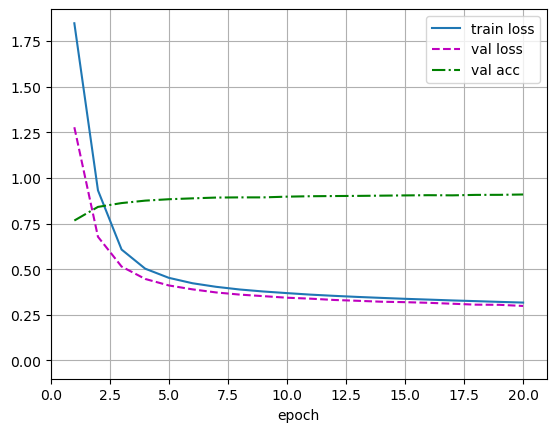

In [3]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1e-1))
if True:
    ml.train(num_epochs=20)  # 训练
    if True:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [4]:
ml.test()  # 测试

Accuracy rate 0.9138


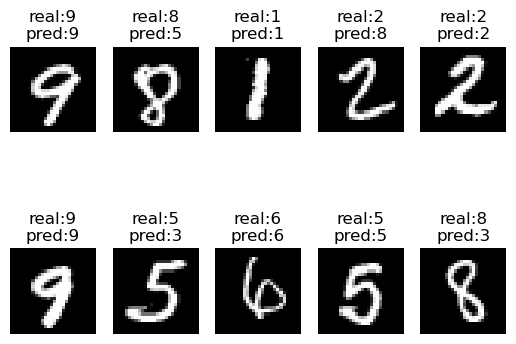

In [5]:
ml.predict()  # 预测